# OpenStreetMap (OSM) data for Podgorica, Montenegro

In [ ]:
# Loading of packages required for this Notebook

%pip install quackosm folium matplotlib mapclassify ipywidgets --quiet

## Uvod

## Opis glavnih termina i biblioteka korištenih u radu

#### OpenStreetMap (OSM)

> Besplatna, kolaborativna mapa svijeta koju kreira i održava globalna zajednica volontera. Omogućava svima da uređuju, koriste i dijele geografske podatke poput puteva, zgrada i znamenitosti, što je čini široko korišćenim resursom za navigaciju, istraživanje i kartografske projekte. Dostupna na [www.openstreetmap.org](www.openstreetmap.org) 

#### PBF (Protocolbuffer Binary Format)
> Kompaktan binarni format koji se koristi za skladištenje podataka iz OpenStreetMap-a (OSM). Dizajniran je za efikasno čuvanje velikih količina geografskih informacija, kao što su čvorovi, putevi i relacije, u manjoj veličini fajla u poređenju sa običnim XML formatom. PBF fajlovi se brže čitaju i pišu, što ih čini pogodnim za obradu i prenos velikih OSM datasetova.

#### GeoPandas - python biblioteka
> Open-source Python biblioteka koja proširuje mogućnosti pandas biblioteke za rad sa geoprostornim podacima. Omogućava jednostavnu manipulaciju, analizu i vizualizaciju geografskih informacija, integracijom sa bibliotekama poput shapely za geometrijske operacije i matplotlib za crtanje. GeoPandas podržava uobičajene prostorne formate fajlova, kao što su shapefiles i GeoJSON.

#### GeoDataFrame
> Struktura podataka u GeoPandas-u koja proširuje pandas DataFrame za skladištenje geoprostornih podataka, sa kolonom za geometriju koja predstavlja geografske karakteristike i omogućava prostorne operacije.

#### QuackOSM - python biblioteka
> Python biblioteka koja omogućava jednostavan pristup podacima iz OpenStreetMap (OSM) kroz API pozive. Ova biblioteka pruža alate za preuzimanje, analizu i manipulaciju OSM podacima, olakšavajući korisnicima rad sa geografskim informacijama. QuackOSM podržava različite operacije, uključujući pretragu po oznakama i geografskoj lokaciji, što je čini korisnom za projekte vezane za prostornu analizu i vizualizaciju.

#### DuckDB - Python biblioteka
> Pruža brzu i efikasnu analizu podataka koristeći sistem za upravljanje relacionim bazama podataka. Inspirisana SQLite-om, DuckDB je optimizovana za rad sa velikim skupovima podataka i analitičkim operacijama. Omogućava korisnicima da izvode SQL upite direktno iz Python okruženja, podržava rad sa različitim formatima podataka, kao što su Parquet i CSV, i može se lako integrisati sa popularnim bibliotekama poput pandas.

#### Parquet fajl format
> Kolonarni format za skladištenje podataka, pogodan za velike prostorne datasetove. Omogućava efikasno čitanje, kompresiju i evoluciju šeme, a uz bibliotekepoput GeoPandas-a koristi se za analizu i obradu podataka u GIS aplikacijama.


## Upotreba QuackOSM za pronalažanje i download podataka sa OSM

### Biblioteka komunicira sa provajderima OSM podataka kao sto su geofabrik.de i preuzima PBF fajlove 

Prvo je potrebno zadati gemetriju koja se pretražuje u OSM podacima. Postoji više načina za ovaj korak a najpopularnija su ova dva:
1. Ručno zadavanje koordinata geometrije
2. Dobijanje geometrije na osnovu nekog pojma ili naziva

U našem slučaju izabrali smo pristup br.2, pretragu za Glavni grad Podgorica.

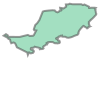

In [1]:
import quackosm as qosm

# Finding geometry of Podgorica
area_podgorica = qosm.geocode_to_geometry("Capital Podgorica, Montenegro")
area_podgorica # Display found geometry

Nakon što imamo željenu geometriju, možemo iskoristi QuackOSM biblioteku da pronađemo PBF ekstrakte koji pokrivaju ovu geometriju.
U nekim slučajevima zadana geometrija nije pokrivena samo jednim PBF ekstraktom, mora se spustiti više fajlova. U našem slučaju geometrija za Glavni grad podgorica je pokrivena jednim fajlom (https://download.geofabrik.de/europe/montenegro.html)

In [2]:
# Find suitable PBF file(s) of OSM that covers Podgorica geometry 
# And filter out OSM features only for that area
# And load in GeoDataFrame
gdf = qosm.convert_geometry_to_geodataframe(area_podgorica)
gdf # Show sample from downloaded and extracted GeoDataFrame

,tags,geometry
feature_id,,
node/1973623586,"{'name:en': 'Bite', 'shop': 'bakery'}",POINT (19.25291 42.44404)
node/1973623590,{'shop': 'florist'},POINT (19.25289 42.44397)
node/1973623605,"{'amenity': 'pharmacy', 'healthcare': 'pharmac...",POINT (19.25295 42.44411)
node/2166373388,{'railway': 'level_crossing'},POINT (19.22307 42.50433)
node/4155519851,"{'name': 'Radan', 'name:sr': 'Радан', 'place':...",POINT (19.50443 42.53481)
...,...,...
way/1127731583,{'highway': 'footway'},"LINESTRING (19.29596 42.47239, 19.29595 42.472..."
way/1127731584,"{'leisure': 'pitch', 'sport': 'soccer', 'surfa...","POLYGON ((19.29633 42.47278, 19.2968 42.47283,..."
way/1127731585,"{'leisure': 'pitch', 'sport': 'basketball', 's...","POLYGON ((19.2961 42.47283, 19.29629 42.47285,..."


#### Vizuelna provjera ekstrakovanih podataka 

Upoređujemo geometrije za Podgoricu, granicama pokrivenim u PBF fajlu i na kraju ekstraktovanim OSM objektima za zadatu regiju

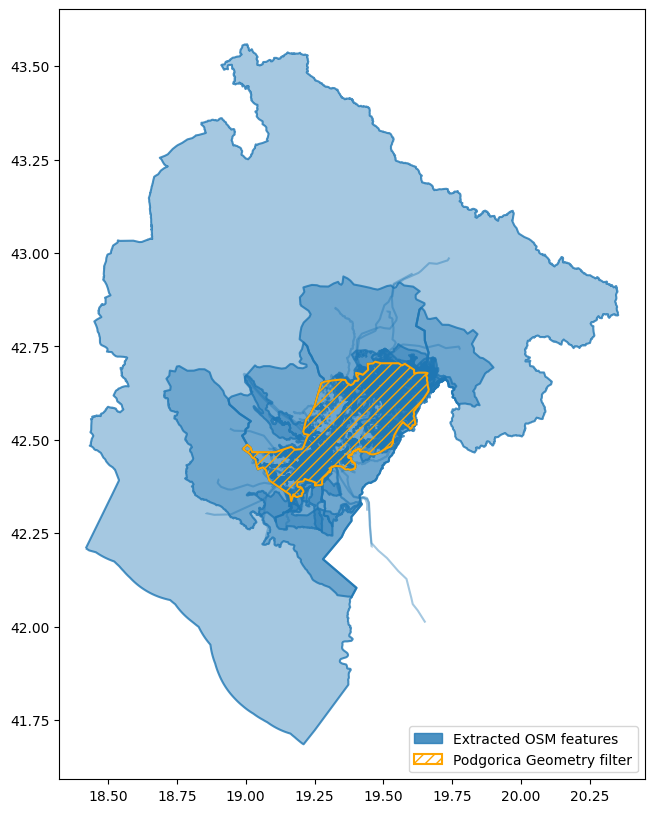

In [3]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd

fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()

gdf.plot(ax=ax, markersize=1, zorder=1, alpha=0.4)
gdf.boundary.plot(ax=ax, markersize=0, zorder=1, alpha=0.8)
gpd.GeoSeries([area_podgorica], crs=4326).plot(
    ax=ax,
    color=(0, 0, 0, 0),
    zorder=2,
    hatch="///",
    edgecolor="orange",
    linewidth=1.5,
    
)

blue_patch = mpatches.Patch(color="C0", alpha=0.8, label="Extracted OSM features")
orange_patch = mpatches.Patch(
    facecolor=(0, 0, 0, 0), edgecolor="orange", hatch="///", linewidth=1.5, label="Podgorica Geometry filter"
)
ax.legend(handles=[blue_patch, orange_patch], loc="lower right")
plt.show()

### Provjera dostupnosti podataka vezanih za institucije obrazovanja u Podgorici

In [6]:
import geopandas as gpd

filter_kindergarten ={"building": "kindergarten", "amenity": "kindergarten"}
filter_school ={"building": "school", "amenity": "school"}
filter_university ={"building": "university", "amenity": "university"}


# Select only OSM features that represent kindergartens in Podgorica area
gdf = qosm.convert_geometry_to_geodataframe(area_podgorica, tags_filter=filter_kindergarten, verbosity_mode="transient", keep_all_tags=True, explode_tags=True)
# Select only OSM features that represent schools in Podgorica area
gdf1 = qosm.convert_geometry_to_geodataframe(area_podgorica, tags_filter=filter_school, verbosity_mode="transient", keep_all_tags=True, explode_tags=True)
# Select only OSM features that represent universities in Podgorica area
gdf2 = qosm.convert_geometry_to_geodataframe(area_podgorica, tags_filter=filter_university, verbosity_mode="transient", keep_all_tags=True, explode_tags=True)

# Prepare 3 layers with different colors
m = gdf.explore(color="orangered", tiles="CartoDB positron")
m2 = gdf1.explore(color="blue", m=m)
m3 = gdf2.explore(color="pink", m=m)

# Draw interactive map for data visualisation and exploration
gpd.GeoSeries([area_podgorica], crs=4326).boundary.explore(m=m)

### Provjera OSM podataka za javni prevoz na teritoriji podgorice

QuackOSM biblioteka ne podržava ekstrakciju linija gradskog prevoza, jer su zadate kao OSM objekat tipa relacija.

Ovdje smo primijenili DuckDB biblioteku sa Spatial ekstenzijom koja jednostavno učitava PBF fajl i daje rezultate u DataFrame.

In [7]:
import duckdb
import geopandas

# Using DuckDB load bus routes
duckdb.load_extension("spatial")
bus_routes_unnested = duckdb.sql(
    """
    SELECT
        id,
        tags as route_tags,
        UNNEST(refs) as ref,
        UNNEST(ref_types) as ref_type,
        UNNEST(ref_roles) as ref_role
    FROM ST_ReadOSM("files/geofabrik_europe_montenegro.osm.pbf")
    WHERE kind = 'relation'
    AND tags['route'][1] = 'bus'
    """
).to_df()

# Combine the data in one object
bus_routes_unnested["feature_id"] = (
    bus_routes_unnested["ref_type"].astype(str) + "/" + bus_routes_unnested["ref"].astype(str)
)

# Load highway and public_transport features
highway_filter = {"highway": True, "public_transport": True}

features_gdf = qosm.convert_osm_extract_to_geodataframe(
    "geofabrik_europe_montenegro", tags_filter=highway_filter, keep_all_tags=True, geometry_filter=area_podgorica
)

features_gdf.explore()

bus_routes_with_geometries = bus_routes_unnested.merge(features_gdf, left_on="feature_id", right_index=True)
bus_routes_with_geometries = bus_routes_with_geometries.rename(
    columns={
        "id": "relation_route_id",
        "tags": "feature_tags",
    }
)

gdf = geopandas.GeoDataFrame(bus_routes_with_geometries, geometry="geometry", crs=4326)
gpd.GeoSeries([area_podgorica], crs=4326).boundary.explore(m=gdf.explore(color="orangered", tiles="CartoDB positron"))

## Analiza pokrivenosti obrazovnih institucija gradskim prevozom

TODO: Različiti metodi analize 

## Vizuelizicija podataka i priprema podataka za dalju upotrebu

TODO: Istražiti različite metode vizualizacije
TODO: Istražiti metode exporta, i omugužavanja pristupa podacima za druge upotrebe.